<a href="https://colab.research.google.com/github/AlCatt91/datascience-portfolio/blob/main/brain_tumor_detector_with_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(open in Colab to correctly display interactive charts and widget)

# Brain Tumor Detector with ResNet




0. [Introduction](#0)

1.  [Preparation](#1)

    1.1 [Packages](#1.1)
    
    1.2 [Data](#1.2)

2. [Classification model](#2)

3. [A widget for inference](#3)

# 0. Introduction <a id=0></a>

In modern medicine, neuroimaging provides an essential tool for physicians to diagnose intracranial injuries or diseases, such as tumors. Computer vision/ML models can be trained to assist medics and radiologists in analyzing patients' scans and their use is becoming more and more widespread. Using fastai we show how to train a convolutional neural network which can identify the presence of a tumor in a brain scan with an accuracy of over 99%.

## 1. Preparation <a name=1></a>

### 1.1 Packages <a name=1.1></a>

In [ ]:
!pip install -q kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

import numpy as np
import pandas as pd

import plotly
import plotly.express as px

!pip install -Uqq fastbook

import fastbook
fastbook.setup_book()

from fastai.data.all import *
from fastai.vision.all import *
from fastai.text.all import *
from fastai.vision.widgets import *
from fastbook import *

warnings.filterwarnings(action='ignore', category=UserWarning)

### 1.2 Data <a name=1.2></a>

We merge the two following datasets, both contaning images from brain scans.

1. https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection
2. https://www.kaggle.com/preetviradiya/brian-tumor-dataset

For convenience we create a dataframe which keeps track of all the images' paths, the corresponding labels (Tumor/No tumor) and pixel sizes.

In [4]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

 60% 9.00M/15.1M [00:00<00:00, 32.6MB/s]
100% 15.1M/15.1M [00:00<00:00, 50.9MB/s]
 92% 99.0M/107M [00:01<00:00, 57.5MB/s]
100% 107M/107M [00:02<00:00, 55.9MB/s] 


In [ ]:
!mkdir brian-tumor-dataset
!mkdir brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip -d brain-mri-images-for-brain-tumor-detection
!unzip brian-tumor-dataset.zip -d brian-tumor-dataset

In [7]:
path1 = Path('brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set')
path2 = Path('brain-mri-images-for-brain-tumor-detection')
im_paths = L(*get_image_files(path1), *get_image_files(path2))

lbl_dct = {'no': 'No tumor', 'yes': 'Tumor', 'Healthy':'No tumor', 'Brain Tumor':'Tumor'}

df = pd.DataFrame({'image':im_paths})
df['px_size'] = df.apply(lambda x: PILImage.create(x.image).size, axis=1)
df['label'] = df.apply(lambda x: lbl_dct[parent_label(x.image)], axis=1)

df.head()

,image,px_size,label
0,brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer (661).jpg,"(232, 217)",No tumor
1,brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer (1364).jpg,"(173, 201)",No tumor
2,brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer (296).jpg,"(236, 357)",No tumor
3,brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer (2073).jpg,"(225, 225)",No tumor
4,brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer (1923).jpg,"(428, 417)",No tumor


In [8]:
df.value_counts('label')

label
Tumor       2823
No tumor    2283
dtype: int64

The dataset in not perfectly balanced, with an excess of scans from partients with tumors.

In order to collate images into batches to pass to the neural network, we need all images to have the same size. We look at the sizes' distribution in order to choose a good resize shape.

In [9]:
w, h = list(zip(*df['px_size'].values))

sizesdf = pd.DataFrame({'width':w, 'height':h, 'label':df.label.values})

fig = px.scatter(sizesdf, x='width', y='height', color='label',
           marginal_x='violin', marginal_y='violin', title='Image sizes (pixel)', height=800)

fig.show()

The images are, for the most part, approximately square-shaped. We will reshape all images to be of size (360, 360). The resizing is performed by squishing: we avoid cropping since it might miss the tumor location.

## 2. Classification model <a name=2></a>

Let us create the train and validation dataloaders to feed to the neural network: we do it by using the high-level API provided by fastai, which automatically performs the image preprocessing and the label numericalization.

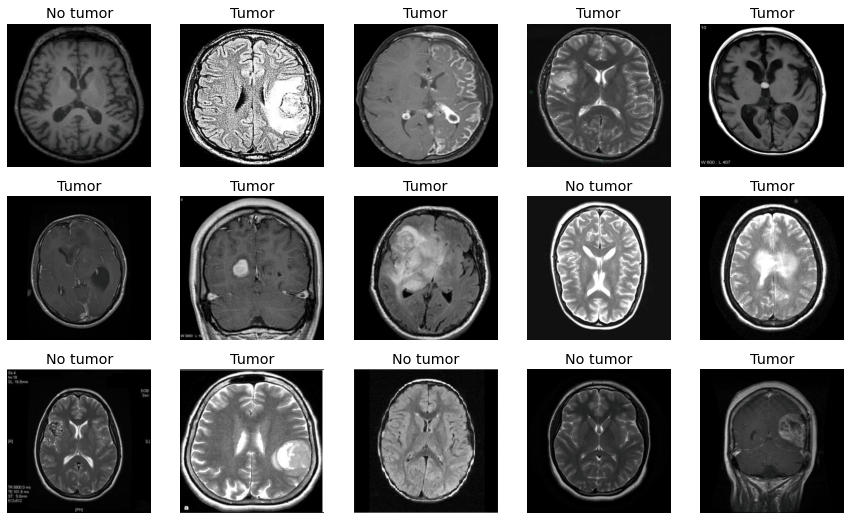

In [10]:
dblock = DataBlock.from_columns(blocks=(ImageBlock, CategoryBlock),
                               get_items=lambda x: (x.image, x.label),
                               item_tfms=Resize(360, method='squish'),
                               #batch normalization
                               batch_tfms=Normalize.from_stats(*imagenet_stats)) 

dls = dblock.dataloaders(df)

dls.show_batch(max_n=15)

In [11]:
print(f"Size of training set: {len(dls.train.items)}")
print(f"Size of validation set: {len(dls.valid.items)}")

Size of training set: 4085
Size of validation set: 1021


We train a residual neural network using the `resnet34` architecture, with cross entropy as loss function. We use *gradual unfreezing*: for the first two epochs we train only the classifier head, then we unfreeze the encoder's layers and train all weigths for 5 more epochs. This is done with the `fine_tune` method of fastai's `Learner` class.

In [19]:
learn = cnn_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [20]:
learn.fine_tune(6, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,time
0,0.623952,0.151108,0.931440,01:04
1,0.313170,0.086719,0.966699,01:05


epoch,train_loss,valid_loss,accuracy,time
0,0.109303,0.032614,0.992165,01:31
1,0.078768,0.138479,0.951028,01:31
2,0.055874,0.016869,0.996082,01:31
3,0.022046,0.012175,0.995103,01:31
4,0.009203,0.013471,0.995103,01:31
5,0.003464,0.012414,0.995103,01:31


Without many tweakings, the approach based on convolutional neural networks has produced a model with an accuracy of 99.5% on the validation set! Let us take a look at the confusion matrix and the corresponding classification report.

              precision    recall  f1-score   support

    No tumor       0.99      1.00      0.99       455
       Tumor       1.00      0.99      1.00       566

    accuracy                           1.00      1021
   macro avg       0.99      1.00      1.00      1021
weighted avg       1.00      1.00      1.00      1021



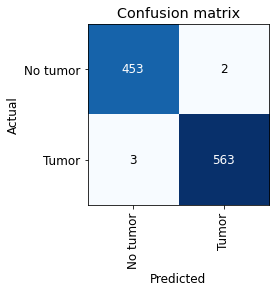

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

interp.print_classification_report()

The few errors are spread evenly among the two labels: the unbalanced dataset does not appear to have induced any bias in the model. Here are the five misclassified images, with the corresponding losses.

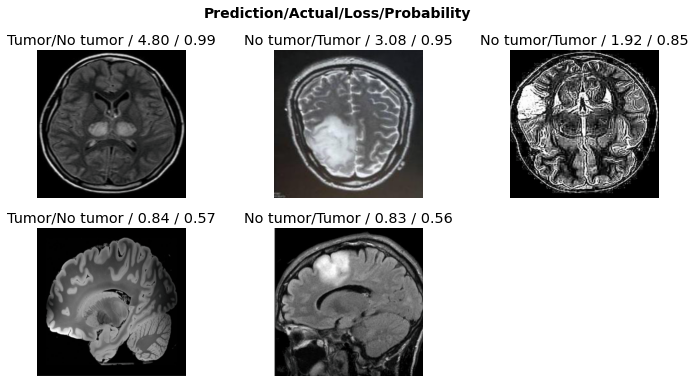

In [28]:
interp.plot_top_losses(k=5, figsize=(12,6))

## 3. A widget for inference <a name=3></a>

To conclude, we build a practical **widget** which allows the user to upload the image of a brain scan and get our model's prediction by simply clicking a button.

In [30]:
outp = widgets.Output()
upload_btn = widgets.FileUpload()
pred_label = widgets.Label()

def on_click_cl(change):
    brain = PILImage.create(upload_btn.data[-1])
    outp.clear_output()
    with outp: display(brain.to_thumb(180,180))
    pred, idx, probs = learn.predict(brain)
    pred_label.value = f'The model predicts: {pred}, with probability: {probs[idx]:.03f}'

cl_btn = widgets.Button(description='Classify')
cl_btn.on_click(on_click_cl)

VBox([widgets.Label('Upload brain scan image, then click on "Classify"'), upload_btn, cl_btn, outp, pred_label])